<a href="https://colab.research.google.com/github/EfandraEka/CAPSTONE-PROJECT_Minggu1/blob/main/CAPSTONE_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk modeling dan preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Untuk menangani data imbalance
from imblearn.over_sampling import SMOTE

# Untuk menyimpan model
import pickle

Penjelasan:
- pandas, numpy: manipulasi data
- seaborn, matplotlib: visualisasi
- sklearn: preprocessing, modeling, evaluasi
- imblearn: menangani ketidakseimbangan kelas (SMOTE)
- pickle: menyimpan model untuk deployment

In [2]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/ObesityDataSet.csv')  # Ubah sesuai path file Anda

Penjelasan:
Membaca file CSV dan menyimpannya ke dalam DataFrame df.

In [4]:
# Info dasar tentang dataset
print(df.head())                # 5 baris pertama
print(df.info())                # Tipe data dan non-null
print(df.describe())            # Statistik deskriptif
print(df.nunique())             # Jumlah nilai unik per kolom

  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weight  
2        Normal_W

Penjelasan:
Memberi gambaran awal isi dataset, seperti jumlah data, tipe fitur, dan statistiknya.

In [5]:
# Cek missing values dan duplikat
print("Missing values:\n", df.isnull().sum())
print("Jumlah duplikasi:", df.duplicated().sum())

Missing values:
 Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64
Jumlah duplikasi: 18


Penjelasan:

- Mengecek apakah ada data kosong (missing values) dan data yang sama persis (duplikat).

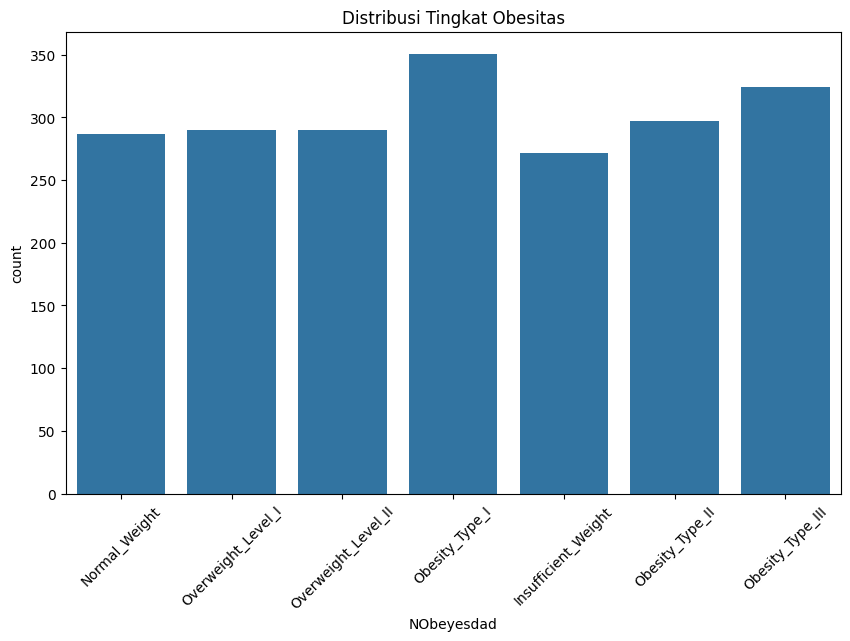

In [6]:
# Visualisasi distribusi kelas target
plt.figure(figsize=(10,6))
sns.countplot(x="NObeyesdad", data=df)
plt.xticks(rotation=45)
plt.title("Distribusi Tingkat Obesitas")
plt.show()

Penjelasan:
Menampilkan jumlah data per kategori obesitas. Ini penting untuk melihat apakah data target seimbang atau tidak.

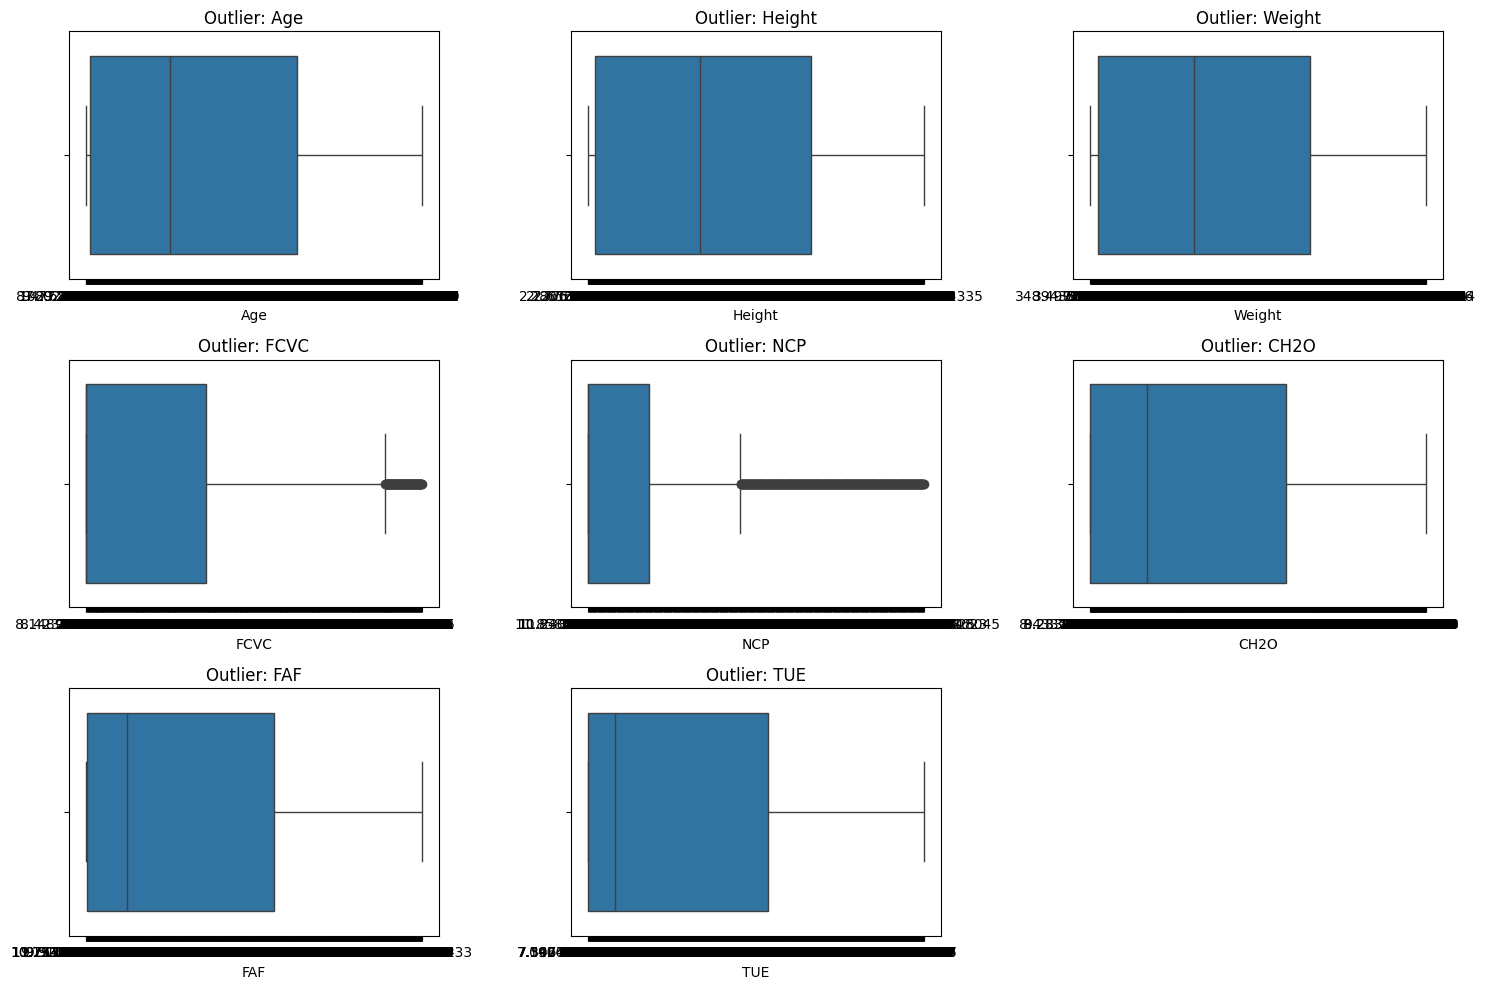

In [7]:
# Deteksi outlier dengan boxplot
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Outlier: {col}')
plt.tight_layout()
plt.show()

Penjelasan:
Boxplot membantu mendeteksi outlier (nilai ekstrem) pada fitur numerik.

In [8]:
#  Hapus duplikasi jika ada
df = df.drop_duplicates()

In [9]:
# Label Encoding kolom kategorikal
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
                    'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

Age                               object
Gender                             int64
Height                            object
Weight                            object
CALC                               int64
FAVC                               int64
FCVC                              object
NCP                               object
SCC                                int64
SMOKE                              int64
CH2O                              object
family_history_with_overweight     int64
FAF                               object
TUE                               object
CAEC                               int64
MTRANS                             int64
NObeyesdad                         int64
dtype: object
Unique values in Age: ['21' '23' '27' ... '22.524036' '24.361936' '23.664709']
Unique values in Height: ['1.62' '1.52' '1.8' ... '1.752206' '1.73945' '1.738836']
Unique values in Weight: ['64' '56' '77' ... '133.689352' '133.346641' '133.472641']
Unique values in FCVC: ['2' '3' '1' nan '?

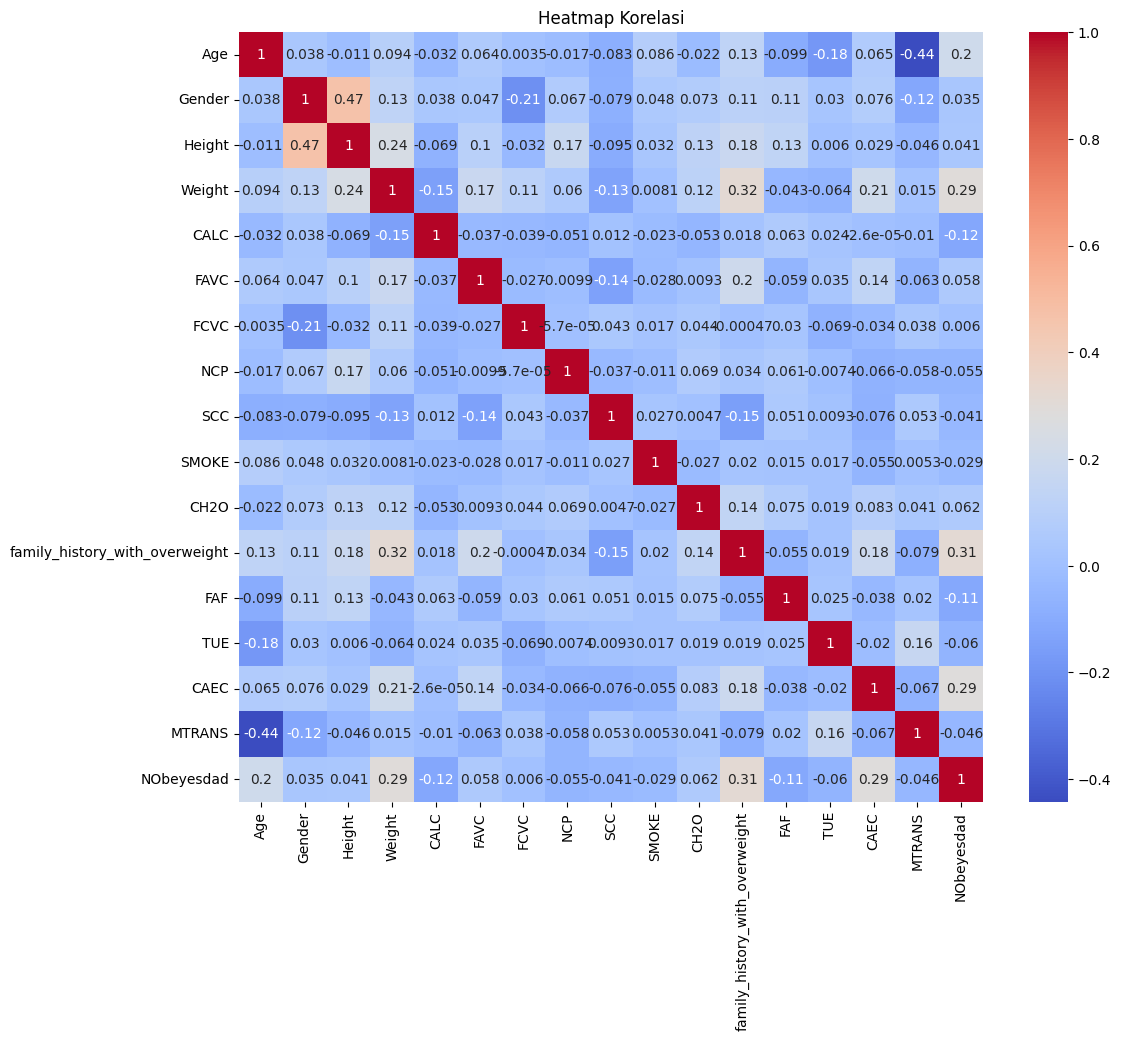

In [15]:
# Visualisasi korelasi antar fitur
print(df.dtypes)
for col in df.select_dtypes(include='object').columns:
    print(f"Unique values in {col}: {df[col].unique()}")
for col in df.columns:
    if df[col].dtype == 'object':
        if '?' in df[col].unique():
            print(f"Column '{col}' contains '?'. Replacing with NaN.")
            df[col] = df[col].replace('?', np.nan)
df = df.dropna()
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi")
plt.show()

Penjelasan:
Menghapus baris yang identik untuk menjaga keunikan data.

In [16]:
# Pisahkan fitur dan target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

In [17]:
# Tangani data imbalance dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [18]:
# Normalisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

Penjelasan:
Normalisasi dengan StandardScaler mengubah data numerik agar memiliki distribusi standar (mean=0, std=1). Sangat berguna untuk algoritma berbasis jarak seperti KNN, SVM.



In [19]:
# Split data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)


Model: Logistic Regression
Accuracy: 0.7445887445887446
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        73
           1       0.73      0.49      0.59        67
           2       0.76      0.58      0.66        65
           3       0.76      0.91      0.83        66
           4       0.95      0.97      0.96        73
           5       0.59      0.60      0.59        57
           6       0.58      0.61      0.59        61

    accuracy                           0.74       462
   macro avg       0.73      0.73      0.73       462
weighted avg       0.74      0.74      0.74       462



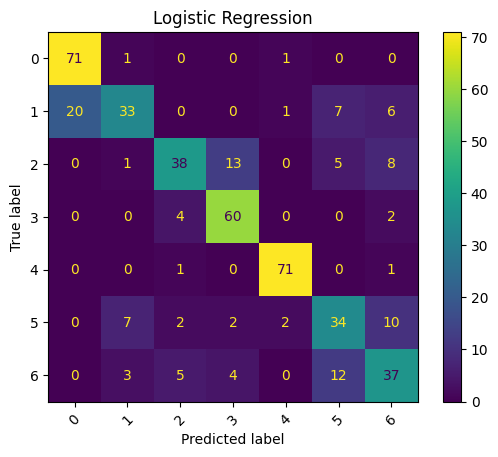


Model: Random Forest
Accuracy: 0.9696969696969697
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        73
           1       0.89      0.99      0.94        67
           2       1.00      0.98      0.99        65
           3       0.99      1.00      0.99        66
           4       1.00      1.00      1.00        73
           5       0.96      0.89      0.93        57
           6       0.95      0.98      0.97        61

    accuracy                           0.97       462
   macro avg       0.97      0.97      0.97       462
weighted avg       0.97      0.97      0.97       462



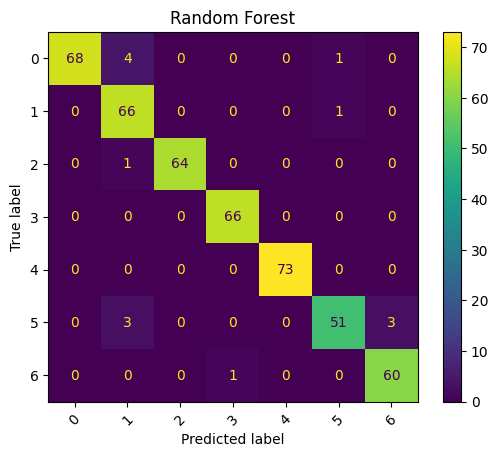


Model: SVM
Accuracy: 0.803030303030303
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        73
           1       0.58      0.67      0.62        67
           2       0.92      0.75      0.83        65
           3       0.87      0.94      0.91        66
           4       0.96      0.93      0.94        73
           5       0.61      0.72      0.66        57
           6       0.81      0.70      0.75        61

    accuracy                           0.80       462
   macro avg       0.81      0.80      0.80       462
weighted avg       0.82      0.80      0.81       462



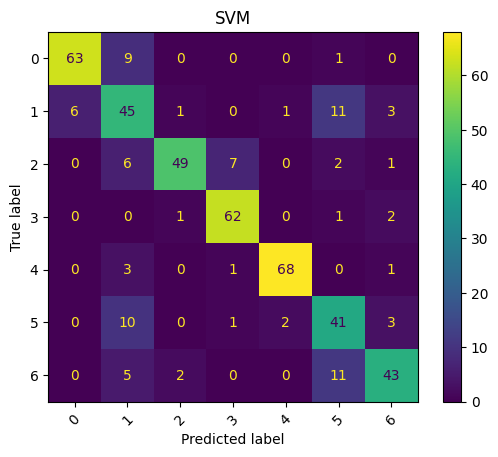

In [20]:
# Inisialisasi 3 model
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

# Latih & evaluasi tiap model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(xticks_rotation=45)
    plt.title(name)
    plt.show()

In [ ]:
print("""
KESIMPULAN TAHAP PREPROCESSING:

1. Duplikasi berhasil dihapus. Tidak ditemukan missing values.
2. Outlier dihapus menggunakan metode IQR pada fitur numerik.
3. Semua data kategorikal telah diubah ke bentuk numerik menggunakan LabelEncoder.
4. Ketidakseimbangan data berhasil ditangani dengan SMOTE.
5. Data telah dinormalisasi dengan StandardScaler untuk mendukung algoritma machine learning.
6. Dataset telah siap digunakan untuk pelatihan dan pengujian model klasifikasi obesitas.
""")


KESIMPULAN TAHAP PREPROCESSING:

1. Duplikasi berhasil dihapus. Tidak ditemukan missing values.
2. Outlier dihapus menggunakan metode IQR pada fitur numerik.
3. Semua data kategorikal telah diubah ke bentuk numerik menggunakan LabelEncoder.
4. Ketidakseimbangan data berhasil ditangani dengan SMOTE.
5. Data telah dinormalisasi dengan StandardScaler untuk mendukung algoritma machine learning.
6. Dataset telah siap digunakan untuk pelatihan dan pengujian model klasifikasi obesitas.




Model Random Forest setelah Tuning:
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9653679653679653
              precision    recall  f1-score   support

           0       0.99      0.93      0.96        73
           1       0.88      0.97      0.92        67
           2       0.98      0.98      0.98        65
           3       0.99      1.00      0.99        66
           4       1.00      1.00      1.00        73
           5       0.96      0.89      0.93        57
           6       0.97      0.97      0.97        61

    accuracy                           0.97       462
   macro avg       0.97      0.96      0.96       462
weighted avg       0.97      0.97      0.97       462



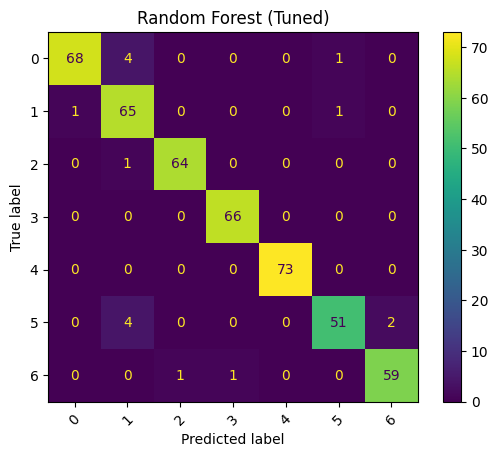

In [22]:
# Grid Search untuk Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Model terbaik
best_model = grid_search.best_estimator_

# Evaluasi ulang
y_pred_best = best_model.predict(X_test)
print("\nModel Random Forest setelah Tuning:")
print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best)).plot(xticks_rotation=45)
plt.title("Random Forest (Tuned)")
plt.show()

In [27]:
# Simpan model dan scaler untuk digunakan di Streamlit
pickle.dump(best_model, open('model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))